In [ ]:
import pandas as pd
import numpy as np
import glob
import time
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import numpy
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import date, timedelta
from itertools import groupby
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VARMAX
import statsmodels.api as sm
import IPython
import IPython.display
from keras import backend as K
import pdb
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
final_df = pd.read_pickle("./drive/MyDrive/final_df.pkl")

In [ ]:
final_df.head()

,date,speed-min,speed-max,speed-average,speed-std,direction-min,direction-max,direction-average,direction-std,greek_city_name,city_name,latitude,longitude,city_code,cosine-speed,sinus-speed
5434415,1999-09-02,1.7,4.0,3.1,0.4,319.1,9.7,349.7,8.2,Σιθωνία,Sithonia,40.011389,23.944167,105,3.088779,-0.263524
7709615,1999-09-02,0.2,0.2,0.2,0.0,157.5,167.3,160.2,4.5,ΒΛΟΓΓΟΣ,Balogen,37.582778,22.005833,314,-0.193737,0.049658
8847215,1999-09-02,4.1,9.5,6.9,0.9,356.8,48.8,18.7,8.4,Πλάκα,Plate,40.900000,25.745000,123,6.297398,2.820067
3728015,1999-09-02,7.9,11.7,10.5,0.5,24.4,44.1,35.6,6.7,Μαλούνι,Male,39.626389,20.501389,217,7.921621,6.891874
1794095,1999-09-02,4.8,8.6,7.1,0.7,287.3,339.4,306.6,9.3,Γλαφυρά,Glamor,39.433611,22.856944,211,4.752994,-5.274377


In [ ]:
speed_df = final_df[['date','speed-average','city_code']]
speed_df.index = speed_df['date']
speed_df = speed_df[['speed-average','city_code']]
speed_df.head()

,speed-average,city_code
date,,
1999-09-02,3.1,105
1999-09-02,0.2,314
1999-09-02,6.9,123
1999-09-02,10.5,217
1999-09-02,7.1,211


In [ ]:
speed_direction_df = final_df[['date','cosine-speed','sinus-speed','city_code']]
speed_direction_df.index = speed_direction_df['date']
speed_direction_df = speed_direction_df[['cosine-speed','sinus-speed','city_code']]
speed_direction_df.head()

,cosine-speed,sinus-speed,city_code
date,,,
1999-09-02,3.088779,-0.263524,105
1999-09-02,-0.193737,0.049658,314
1999-09-02,6.297398,2.820067,123
1999-09-02,7.921621,6.891874,217
1999-09-02,4.752994,-5.274377,211


In [ ]:
speed_direction_df_101 = speed_direction_df[speed_direction_df['city_code']==101][['cosine-speed','sinus-speed']]

# Multi-steps LSTM model exploration

In [ ]:
BATCH_SIZE_ = 32
MAX_EPOCHs = 100

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               BATCH_SIZE=BATCH_SIZE_, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.BATCH_SIZE = BATCH_SIZE

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

  def split_window(self, features, targets=None):
    
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='cosine-speed', max_subplots=3):
    
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.plot(self.input_indices/6, 
               inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices/6, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices/6, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time (in hours)')
    plt.ylabel(str(plot_col)+ " (in m/s)")
    
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=self.BATCH_SIZE,
          seed=0)

    ds = ds.map(self.split_window)

    return ds

  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


def compile_and_fit(model, window, patience=10, MAX_EPOCHS = MAX_EPOCHs):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=l2_distance_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[l2_distance,speed_error,direction_error])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      verbose = False)
  return history

def l2_distance(y_true, y_pred):
  return K.sqrt(K.sum((y_true - y_pred)**2, axis=2))

def l2_distance_loss(y_true, y_pred):
  return K.sum((y_true - y_pred)**2, axis=2)

def some_function(tensor):
  valid_angle=tensor[0]
  prediction_angle=tensor[1]
  if K.abs(valid_angle-prediction_angle) < math.pi:
    return K.abs(valid_angle-prediction_angle)
  return 2*math.pi - K.abs(valid_angle-prediction_angle)

def direction_error(y_true, y_pred):
    valid_direction = tf.math.atan(y_true[:,:,1]/y_true[:,:,0])
    prediction_direction = tf.math.atan(y_pred[:,:,1]/y_pred[:,:,0])
    c = tf.transpose([valid_direction,prediction_direction])[0]
    return tf.map_fn(some_function, c, dtype=tf.float32)
    
def speed_error(y_true, y_pred):
  return K.abs(K.sqrt(K.sum(y_pred**2,axis=2))-K.sqrt(K.sum(y_true**2,axis=2)))

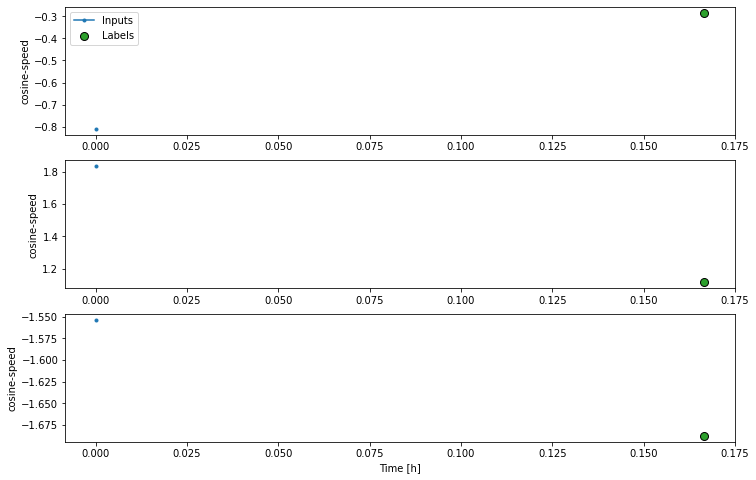

In [ ]:
column_indices = {name: i for i, name in enumerate(speed_direction_df_101.columns)}
n = len(speed_direction_df_101)
train_df = speed_direction_df_101[0:int(n*0.7)]
val_df = speed_direction_df_101[int(n*0.7):int(n*0.9)]
test_df = speed_direction_df_101[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()

num_features = 2

OUT_STEPS = 1
multi_window = WindowGenerator(input_width=1,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                               train_df=train_df, 
                               val_df=val_df, 
                               test_df=test_df,
                               BATCH_SIZE=128,
                               label_columns=['cosine-speed','sinus-speed'])
multi_window.plot()

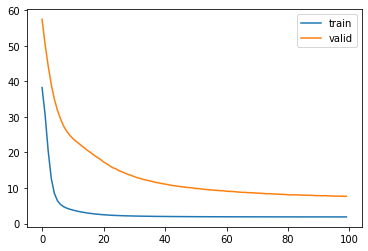

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].                                    
    tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

24/24 [==============================] - 1s 15ms/step - loss: 7.6567 - l2_distance: 1.8326 - speed_error: 1.1672 - direction_error: 0.4615


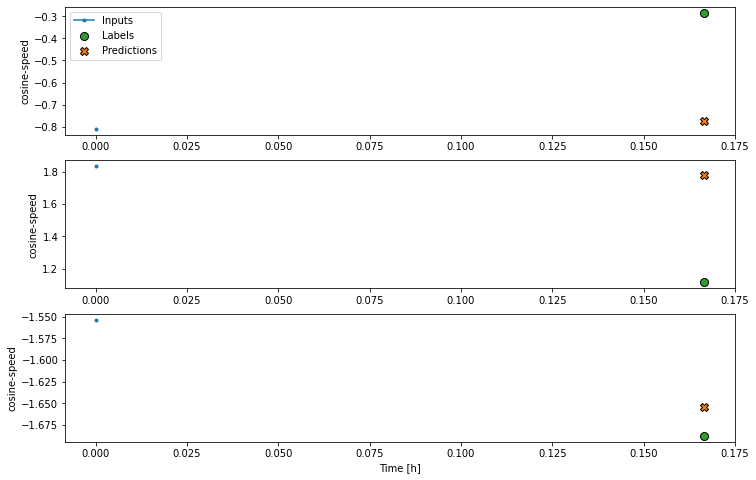

In [ ]:
multi_val_performance = np.array(multi_lstm_model.evaluate(multi_window.val))
multi_performance = np.array(multi_lstm_model.evaluate(multi_window.test, verbose=0))
multi_window.plot(multi_lstm_model)

In [ ]:
print("L2 distance error for multi-steps LSTM :" + str(round(multi_performance[1],3)))
print("Speed error for multi-steps LSTM :" + str(round(multi_performance[2],3)))
print("Distance error for multi-steps LSTM :" + str(round(multi_performance[3],3)))

L2 distance error for multi-steps LSTM :1.766
Speed error for multi-steps LSTM :0.96
Distance error for multi-steps LSTM :0.322


# Location-wise approach

In [ ]:
def fit_evaluate_conv_model_location_wise(multi_window,train_mean,train_std,num_features, OUT_STEPS, CONV_UNITS=256, CONV_WIDTH = 3):
  
  if CONV_WIDTH > 3:
    CONV_WIDTH = 3

  multi_conv_model = tf.keras.Sequential([
      tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(CONV_UNITS, activation='relu', kernel_size=(CONV_WIDTH)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  history = compile_and_fit(multi_conv_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.array(multi_conv_model.evaluate(multi_window.test, verbose=0))

def fit_evaluate_lstm_model_location_wise(multi_window,train_mean,train_std,num_features, OUT_STEPS, LSTM_UNITS):
  multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=train_mean, variance=train_std),                                      
    # Shape [batch, time, features] => [batch, lstm_units].                                    
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])
  history = compile_and_fit(multi_lstm_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.array(multi_lstm_model.evaluate(multi_window.test, verbose=0))

def pipeline_location_wise(df,train_split,val_split,test_split,INPUT_WIDTHS,OUT_STEPS,BATCH_SIZE,LSTM_UNITS,CONV_UNITS):

  train_df = df[train_split]
  val_df = df[val_split]
  test_df = df[test_split]

  train_mean = train_df.mean()
  train_std = train_df.std()

  num_features = 2

  performance = {}

  for INPUT_WIDTH in INPUT_WIDTHS:
    multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                                  label_width=OUT_STEPS,
                                  shift=OUT_STEPS, 
                                  train_df=train_df, 
                                  val_df=val_df, 
                                  test_df=test_df,
                                  BATCH_SIZE=BATCH_SIZE,
                                  label_columns=['cosine-speed','sinus-speed'])

    for LSTM_UNIT in LSTM_UNITS:
      performance["LSTM " + str(LSTM_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_lstm_model_location_wise(multi_window,train_mean,train_std, 
                                                                                  num_features,OUT_STEPS, LSTM_UNIT)
    for CONV_UNIT in CONV_UNITS:
      performance["CONV " + str(CONV_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_conv_model_location_wise(multi_window,train_mean,train_std,
                                                                                                                                      num_features,OUT_STEPS, CONV_UNIT, INPUT_WIDTH)
  return performance

def compare_models_location_wise(INPUT_WIDTHS,OUT_STEPS,BATCH_SIZES,LSTM_UNITS,CONV_UNITS,performance=[]):

  n = len(speed_direction_df_101)

  split_slices = [(slice(0,int(n*0.7)), slice(int(n*0.7),int(n*0.8)), slice(int(n*0.8),n)),
                  #(slice(0,int(n*0.7)), slice(int(n*0.9),n), slice(int(n*0.7),int(n*0.9))),
                  (slice(int(n*0.1)+1,int(n*0.8)), slice(0,int(n*0.1)+1), slice(int(n*0.8),n)),
                  (slice(int(n*0.2)+1,int(n*0.9)), slice(int(n*0.9),n), slice(0,int(n*0.2)+1)),
                  #(slice(int(n*0.3)+1,n), slice(0,int(n*0.1)+1), slice(int(n*0.1)+1,int(n*0.3)+1)),
                  (slice(int(n*0.3)+1,n), slice(int(n*0.2)+1,int(n*0.3)+1), slice(0,int(n*0.2)+1))]

  for train_split, val_split, test_split in split_slices:
    for BATCH_SIZE in BATCH_SIZES:
      print(len(performance))

      list_results_locations = [pd.DataFrame(pipeline_location_wise(speed_direction_df[speed_direction_df['city_code']==city_code][['cosine-speed','sinus-speed']],
                                                                  train_split,val_split,test_split,
                                                                  INPUT_WIDTHS, OUT_STEPS,
                                                                  BATCH_SIZE,LSTM_UNITS,CONV_UNITS),
                                             index=["L2 distance squared", "L2 distance","MAE speed", "MAE direction"]).T
                                for city_code in speed_direction_df["city_code"].unique()]
                                
      performance.append(sum(list_results_locations)/len(list_results_locations))
      with open("./drive/MyDrive/performance_location_wise_" + str(OUT_STEPS) + "_steps.pkl", 'wb') as f:
        pickle.dump(performance, f)

  return sum(performance)/len(performance)

In [ ]:
n = len(speed_direction_df_101)

prediction_test = pipeline_location_wise(speed_direction_df[speed_direction_df['city_code']==105][['cosine-speed','sinus-speed']],
                            train_split=slice(0,int(n*0.7)),
                            val_split=slice(int(n*0.7),int(n*0.8)),
                            test_split=slice(int(n*0.8),n),
                            INPUT_WIDTHS=[6],OUT_STEPS=1,BATCH_SIZE=128,
                            LSTM_UNITS=[128],CONV_UNITS=[128])

In [ ]:
performance_short_term_location_wise_1_step = compare_models_location_wise(INPUT_WIDTHS=[1,6],
                                                                           OUT_STEPS=1,
                                                                           BATCH_SIZES=[128],
                                                                           LSTM_UNITS=[128],
                                                                           CONV_UNITS=[128],
                                                                           performance=performance_short_term_location_wise_1_step)

In [ ]:
with open("./drive/MyDrive/performance_location_wise_1_steps.pkl",'rb') as f:
  performance_short_term_location_wise_1_step = pickle.load(f)
sum(performance_short_term_location_wise_1_step)/len(performance_short_term_location_wise_1_step)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 128 units & 1 INPUT_WIDTH,1.264458,0.832259,0.545298,0.252049
CONV 128 units & 1 INPUT_WIDTH,1.166805,0.812765,0.523851,0.251544
LSTM 128 units & 6 INPUT_WIDTH,1.284882,0.842606,0.555777,0.260101
CONV 128 units & 6 INPUT_WIDTH,1.156197,0.811483,0.525182,0.253018


In [ ]:
n = len(speed_direction_df_101)

prediction_test = pipeline_location_wise(speed_direction_df[speed_direction_df['city_code']==105][['cosine-speed','sinus-speed']],
                            train_split=slice(0,int(n*0.7)),
                            val_split=slice(int(n*0.7),int(n*0.8)),
                            test_split=slice(int(n*0.8),n),
                            INPUT_WIDTHS=[72],OUT_STEPS=72,BATCH_SIZE=128,
                            LSTM_UNITS=[32,64,128],CONV_UNITS=[64,128])

In [ ]:
performance_short_term_location_wise_72_steps = compare_models_location_wise(INPUT_WIDTHS=[72],
                                                                           OUT_STEPS=72,
                                                                           BATCH_SIZES=[128],
                                                                           LSTM_UNITS=[32],
                                                                           CONV_UNITS=[32],
                                                                           performance=performance_short_term_location_wise_72_steps)

In [ ]:
with open("./drive/MyDrive/performance_location_wise_72_steps.pkl",'rb') as f:
  performance_short_term_location_wise_72_steps = pickle.load(f)
sum(performance_short_term_location_wise_72_steps)/len(performance_short_term_location_wise_72_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 32 units & 72 INPUT_WIDTH,18.480085,3.423678,2.272996,0.435930
CONV 32 units & 72 INPUT_WIDTH,15.017010,3.063532,2.097578,0.286751


In [ ]:
performance_short_term_location_wise_144_steps = compare_models_location_wise(INPUT_WIDTHS=[144],
                                                                           OUT_STEPS=144,
                                                                           BATCH_SIZES=[128],
                                                                           LSTM_UNITS=[16],
                                                                           CONV_UNITS=[16])

In [ ]:
with open("./drive/MyDrive/performance_location_wise_144_steps.pkl",'rb') as f:
  performance_short_term_location_wise_144_steps = pickle.load(f)
sum(performance_short_term_location_wise_144_steps)/len(performance_short_term_location_wise_144_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 16 units & 144 INPUT_WIDTH,24.125981,3.920882,2.667396,0.521584
CONV 16 units & 144 INPUT_WIDTH,21.384076,3.657438,2.547400,0.309444


# Single distribution approach

In [ ]:
BATCH_SIZE_ = 32
MAX_EPOCHs = 100

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

class WindowGenerator_all():
  def __init__(self, input_width, label_width, shift,
               train_dfs, val_dfs, test_dfs,
               BATCH_SIZE=BATCH_SIZE_, label_columns=None):
    # Store the raw data.
    self.train_dfs = train_dfs
    self.val_dfs = val_dfs
    self.test_dfs = test_dfs

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_dfs[0].columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.BATCH_SIZE = BATCH_SIZE

    self.train = self.make_dataset(self.train_dfs)
    self.val = self.make_dataset(self.val_dfs)
    self.test = self.make_dataset_test(self.test_dfs)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

  def split_window(self, features, targets=None):
    #pdb.set_trace()
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='cosine-speed', max_subplots=3):
    # plot the unscaled data here
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col}')
      plt.plot(self.input_indices/6, 
               inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices/6, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices/6, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    
  def make_dataset(self, list_data):
    data = np.array(list_data[0], dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=self.BATCH_SIZE,
          seed=0)
    for data in list_data[1:]:
      data = np.array(data, dtype=np.float32)
      ds = ds.concatenate(tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=self.BATCH_SIZE,
          seed=0))
      
    
    ds = ds.map(self.split_window)
    ds = ds.shuffle(len(list(ds)),seed=1)
    return ds

  def make_dataset_test(self, list_data):

    ds_final = []

    for data in list_data:
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(
              data=np.array(data, dtype=np.float32),
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=self.BATCH_SIZE,
              seed=0)
      
      ds_final.append(ds.map(self.split_window))

    return ds_final

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
def fit_evaluate_conv_model_single_distrib(multi_window,train_mean,train_std,num_features, OUT_STEPS, CONV_UNITS=256, CONV_WIDTH = 3):
  
  if CONV_WIDTH > 3:
    CONV_WIDTH = 3

  multi_conv_model = tf.keras.Sequential([
      tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(CONV_UNITS, activation='relu', kernel_size=(CONV_WIDTH)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  history = compile_and_fit(multi_conv_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.mean([np.array(multi_conv_model.evaluate(test, verbose=0)) for test in multi_window.test],axis=0)

def fit_evaluate_lstm_model_single_distrib(multi_window,train_mean,train_std,num_features, OUT_STEPS, LSTM_UNITS):
  multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
    # Shape [batch, time, features] => [batch, lstm_units].                                    
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])
  history = compile_and_fit(multi_lstm_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.mean([np.array(multi_lstm_model.evaluate(test, verbose=0)) for test in multi_window.test],axis=0)

def fit_evaluate_last_model(multi_window,train_mean,train_std):

  last_baseline = MultiStepLastBaseline()
  last_baseline.compile(loss=l2_distance_loss, metrics=[l2_distance,speed_error,direction_error])
  
  return np.mean([np.array(last_baseline.evaluate(test, verbose=0)) for test in multi_window.test],axis=0)

def fit_evaluate_repeat_model(multi_window,train_mean,train_std):

  repeat_baseline = RepeatBaseline()
  repeat_baseline.compile(loss=l2_distance_loss, metrics=[l2_distance,speed_error,direction_error])
  
  return np.mean([np.array(repeat_baseline.evaluate(test, verbose=0)) for test in multi_window.test],axis=0)


def pipeline_single_distrib(train_split,val_split,test_split,INPUT_WIDTHS,OUT_STEPS,BATCH_SIZE,LSTM_UNITS,CONV_UNITS):

  train_dfs = [speed_direction_df[speed_direction_df['city_code']==city_code][['cosine-speed','sinus-speed']][train_split] 
              for city_code in speed_direction_df['city_code'].unique()]
  val_dfs = [speed_direction_df[speed_df['city_code']==city_code][['cosine-speed','sinus-speed']][val_split] 
              for city_code in speed_direction_df['city_code'].unique()]
  test_dfs = [speed_direction_df[speed_direction_df['city_code']==city_code][['cosine-speed','sinus-speed']][test_split] 
              for city_code in speed_direction_df['city_code'].unique()]

  train_mean = pd.concat(train_dfs).mean()
  train_std = pd.concat(train_dfs).std()

  num_features = 2

  multi_window = WindowGenerator_all(input_width=OUT_STEPS,
                                label_width=OUT_STEPS,
                                shift=OUT_STEPS, 
                                train_dfs=train_dfs, 
                                val_dfs=val_dfs, 
                                test_dfs=test_dfs,
                                BATCH_SIZE=BATCH_SIZE,
                                label_columns=['cosine-speed','sinus-speed'])
  
  performance = {"Repeat" : fit_evaluate_repeat_model(multi_window,train_mean,train_std),
                 "Last" : fit_evaluate_last_model(multi_window,train_mean,train_std)}
  
  for INPUT_WIDTH in INPUT_WIDTHS:

    if (len(INPUT_WIDTHS)>1) and (INPUT_WIDTH != OUT_STEPS):
      multi_window = WindowGenerator_all(input_width=INPUT_WIDTH,
                                  label_width=OUT_STEPS,
                                  shift=OUT_STEPS, 
                                  train_dfs=train_dfs, 
                                  val_dfs=val_dfs, 
                                  test_dfs=test_dfs,
                                  BATCH_SIZE=BATCH_SIZE,
                                  label_columns=['cosine-speed','sinus-speed'])

    for LSTM_UNIT in LSTM_UNITS:
        performance["LSTM " + str(LSTM_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_lstm_model_single_distrib(multi_window,train_mean,train_std, 
                                                                                  num_features,OUT_STEPS, LSTM_UNIT)
    for CONV_UNIT in CONV_UNITS:
        performance["CONV " + str(CONV_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_conv_model_single_distrib(multi_window,train_mean,train_std,
                                                                                  num_features,OUT_STEPS, CONV_UNIT, INPUT_WIDTH)
 
  return performance

def compare_models_single_distrib(INPUT_WIDTHS,OUT_STEPS,BATCH_SIZES,LSTM_UNITS,CONV_UNITS,performance=[]):

  n = len(speed_direction_df_101)

  split_slices = [(slice(0,int(n*0.7)), slice(int(n*0.7),int(n*0.8)), slice(int(n*0.8),n)),
                  #(slice(0,int(n*0.7)), slice(int(n*0.9),n), slice(int(n*0.7),int(n*0.9))),
                  (slice(int(n*0.1)+1,int(n*0.8)), slice(0,int(n*0.1)+1), slice(int(n*0.8),n)),
                  (slice(int(n*0.2)+1,int(n*0.9)), slice(int(n*0.9),n), slice(0,int(n*0.2)+1)),
                  #(slice(int(n*0.3)+1,n), slice(0,int(n*0.1)+1), slice(int(n*0.1)+1,int(n*0.3)+1)),
                  (slice(int(n*0.3)+1,n), slice(int(n*0.2)+1,int(n*0.3)+1), slice(0,int(n*0.2)+1))]

  for train_split, val_split, test_split in split_slices:
    for BATCH_SIZE in BATCH_SIZES:
      print(len(performance))

      performance.append(pd.DataFrame(pipeline_single_distrib(train_split,val_split,test_split,INPUT_WIDTHS,OUT_STEPS,
                                                  BATCH_SIZE,LSTM_UNITS,CONV_UNITS),
                                   index=["L2 distance squared", "L2 distance","MAE speed", "MAE direction"]).T)
      with open("./drive/MyDrive/performance_single_distrib_" + str(OUT_STEPS) + "_steps.pkl", 'wb') as f:
        pickle.dump(performance, f)

  return sum(performance)/len(performance)

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 1
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

n = len(speed_direction_df_101)

pipeline_single_distrib(slice(0,int(n*0.7)),slice(int(n*0.7),int(n*0.8)), slice(int(n*0.8),n),
                        INPUT_WIDTHS = [1,6],
                        OUT_STEPS=1,
                        BATCH_SIZE=64,
                        LSTM_UNITS=[64],
                        CONV_UNITS=[64])

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 1
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

performance_single_distrib_1_step = compare_models_single_distrib(INPUT_WIDTHS = [1,6],
                                                                  OUT_STEPS=1,
                                                                  BATCH_SIZES=[128],
                                                                  LSTM_UNITS=[128],
                                                                  CONV_UNITS=[128])

In [ ]:
with open("./drive/MyDrive/performance_single_distrib_1_steps.pkl",'rb') as f:
  performance_single_distrib_1_step = pickle.load(f)
sum(performance_single_distrib_1_step)/len(performance_single_distrib_1_step)

,L2 distance squared,L2 distance,MAE speed,MAE direction
Repeat,1.164920,0.804900,0.513466,0.795663
Last,1.164920,0.805282,0.513466,0.776469
LSTM 64 units & 1 INPUT_WIDTH,1.169679,0.809947,0.523279,0.767494
CONV 64 units & 1 INPUT_WIDTH,1.160164,0.806657,0.519742,0.787607
LSTM 64 units & 6 INPUT_WIDTH,1.138902,0.801541,0.520792,0.758275
CONV 64 units & 6 INPUT_WIDTH,1.153615,0.807431,0.522543,0.780919


In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 72
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

performance_single_distrib_72_steps = compare_models_single_distrib(INPUT_WIDTHS = [72],
                                                                  OUT_STEPS=72,
                                                                  BATCH_SIZES=[128],
                                                                  LSTM_UNITS=[32],
                                                                  CONV_UNITS=[32])

In [ ]:
with open("./drive/MyDrive/performance_single_distrib_72_steps.pkl",'rb') as f:
  performance_single_distrib_72_steps = pickle.load(f)
sum(performance_single_distrib_72_steps)/len(performance_single_distrib_72_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
Repeat,27.974431,4.358951,2.520730,0.724432
Last,17.001100,3.236327,1.925660,0.247833
LSTM 32 units & 72 INPUT_WIDTH,15.100340,3.070427,2.128286,0.284236
CONV 32 units & 72 INPUT_WIDTH,15.062557,3.080853,2.193559,0.259644


In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 144
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

performance_single_distrib_144_steps = compare_models_single_distrib(INPUT_WIDTHS = [144],
                                                                  OUT_STEPS=144,
                                                                  BATCH_SIZES=[128],
                                                                  LSTM_UNITS=[16],
                                                                  CONV_UNITS=[16])

In [ ]:
with open("./drive/MyDrive/performance_single_distrib_144_steps.pkl",'rb') as f:
  performance_single_distrib_144_steps = pickle.load(f)
sum(performance_single_distrib_144_steps)/len(performance_single_distrib_144_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
Repeat,37.654639,4.821883,2.822525,0.723028
Last,25.201890,3.945649,2.322461,0.250066
LSTM 16 units & 144 INPUT_WIDTH,21.301927,3.658559,2.564581,0.308123
CONV 16 units & 144 INPUT_WIDTH,21.494588,3.691733,2.699757,0.274311


# Single entity

In [ ]:
def fit_evaluate_conv_model_grouped(multi_window,train_mean,train_std,num_features, OUT_STEPS, CONV_UNITS=256, CONV_WIDTH = 3):
  
  if CONV_WIDTH > 3:
    CONV_WIDTH = 3

  multi_conv_model = tf.keras.Sequential([
      tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(CONV_UNITS, activation='relu', kernel_size=(CONV_WIDTH)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  history = compile_and_fit(multi_conv_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.array(multi_conv_model.evaluate(multi_window.test, verbose=0))

def fit_evaluate_lstm_model_grouped(multi_window,train_mean,train_std,num_features, OUT_STEPS, LSTM_UNITS):
  multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
    # Shape [batch, time, features] => [batch, lstm_units].                                    
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])
  history = compile_and_fit(multi_lstm_model, multi_window)

  IPython.display.clear_output()

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()

  return np.array(multi_lstm_model.evaluate(multi_window.test, verbose=0))

def create_df_grouped(final_df,city_code_list):
    df_grouped = pd.DataFrame(index=final_df.index.unique())
    for city_code in city_code_list:
        df = final_df[final_df['city_code'] == city_code]
        df = df[['cosine-speed','sinus-speed']]
        df.columns = [column_name+"_"+str(city_code) for column_name in df.columns]
        df_grouped = df_grouped.join(df)
    return df_grouped

def pipeline_single_entity(train_split,val_split,test_split, 
                                        INPUT_WIDTHS, OUT_STEPS, BATCH_SIZE, 
                                        LSTM_UNITS, CONV_UNITS):
  
  performances = []
  for city_code in speed_direction_df["city_code"].unique():
    list_city_code = list(speed_direction_df["city_code"].unique())
    list_city_code.remove(city_code)
    speed_direction_df_grouped = create_df_grouped(speed_direction_df,[city_code] + list_city_code)

    num_features = 2
    train_df = speed_direction_df_grouped[train_split]
    val_df = speed_direction_df_grouped[val_split]
    test_df = speed_direction_df_grouped[test_split]

    train_mean = train_df.mean()
    train_std = train_df.std()

    performance = {}

    for INPUT_WIDTH in INPUT_WIDTHS:

      multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                                    label_width=OUT_STEPS,
                                    shift=OUT_STEPS, 
                                    train_df=train_df, 
                                    val_df=val_df, 
                                    test_df=test_df,
                                    BATCH_SIZE=BATCH_SIZE,
                                    label_columns=list(speed_direction_df_grouped.columns)[:2])
  

      for LSTM_UNIT in LSTM_UNITS:
          performance["LSTM " + str(LSTM_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_lstm_model_grouped(multi_window,train_mean,train_std, 
                                                                                  num_features,OUT_STEPS, LSTM_UNIT)
      for CONV_UNIT in CONV_UNITS:
          performance["CONV " + str(CONV_UNIT) + " units & " + str(INPUT_WIDTH) + " INPUT_WIDTH"] = fit_evaluate_conv_model_grouped(multi_window,train_mean,train_std,
                                                                                  num_features,OUT_STEPS, CONV_UNIT, INPUT_WIDTH)
    performances.append(performance)

  return dict_mean(performances)

def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

def compare_models_single_entity(INPUT_WIDTHS,OUT_STEPS,BATCH_SIZES,LSTM_UNITS,CONV_UNITS,performance=[]):

  n = len(speed_direction_df_101)

  split_slices = [(slice(0,int(n*0.7)), slice(int(n*0.7),int(n*0.8)), slice(int(n*0.8),n)),
                  #(slice(0,int(n*0.7)), slice(int(n*0.9),n), slice(int(n*0.7),int(n*0.9))),
                  (slice(int(n*0.1)+1,int(n*0.8)), slice(0,int(n*0.1)+1), slice(int(n*0.8),n)),
                  (slice(int(n*0.2)+1,int(n*0.9)), slice(int(n*0.9),n), slice(0,int(n*0.2)+1)),
                  #(slice(int(n*0.3)+1,n), slice(0,int(n*0.1)+1), slice(int(n*0.1)+1,int(n*0.3)+1)),
                  (slice(int(n*0.3)+1,n), slice(int(n*0.2)+1,int(n*0.3)+1), slice(0,int(n*0.2)+1))]

  for train_split, val_split, test_split in split_slices:
    for BATCH_SIZE in BATCH_SIZES:
        print(len(performance))

        performance.append(pd.DataFrame(pipeline_single_entity(train_split,val_split,test_split,INPUT_WIDTHS,
                                                               OUT_STEPS,BATCH_SIZE,LSTM_UNITS,CONV_UNITS),
                                    index=["L2 distance squared", "L2 distance","MAE speed", "MAE direction"]).T)
        with open("./drive/MyDrive/performance_single_entity_" + str(OUT_STEPS) + "_steps.pkl", 'wb') as f:
          pickle.dump(performance, f)

  return sum(performance)/len(performance)

In [ ]:
n = len(speed_direction_df_101)

prediction_test = pipeline_single_entity(train_split=slice(0,int(n*0.7)),
                            val_split=slice(int(n*0.7),int(n*0.8)),
                            test_split=slice(int(n*0.8),n),
                            INPUT_WIDTHS=[1,6],OUT_STEPS=1,BATCH_SIZE=128,
                            LSTM_UNITS=[64,128],CONV_UNITS=[64,128])

In [ ]:
performance_single_entity_1_step = compare_models_single_entity(INPUT_WIDTHS=[1,6],
                                                                OUT_STEPS=1,
                                                                BATCH_SIZES=[128],
                                                                LSTM_UNITS=[64],
                                                                CONV_UNITS=[64])

In [ ]:
with open("./drive/MyDrive/performance_single_entity_1_steps.pkl",'rb') as f:
  performance_single_entity_1_step = pickle.load(f)
sum(performance_single_entity_1_step)/len(performance_single_entity_1_step)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 64 units & 1 INPUT_WIDTH,5.733722,1.832559,1.372889,0.446349
CONV 64 units & 1 INPUT_WIDTH,2.396367,1.199162,0.795101,0.360604
LSTM 64 units & 6 INPUT_WIDTH,6.824702,2.016055,1.478824,0.492717
CONV 64 units & 6 INPUT_WIDTH,2.614841,1.271634,0.851216,0.379158


In [ ]:
performance_single_entity_72_steps = compare_models_single_entity(INPUT_WIDTHS=[72],
                                                                OUT_STEPS=72,
                                                                BATCH_SIZES=[128],
                                                                LSTM_UNITS=[16],
                                                                CONV_UNITS=[16])

In [ ]:
with open("./drive/MyDrive/performance_single_entity_72_steps.pkl",'rb') as f:
  performance_single_entity_72_steps = pickle.load(f)
sum(performance_single_entity_72_steps)/len(performance_single_entity_72_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 16 units & 72 INPUT_WIDTH,23.207761,3.918025,2.632696,0.730347
CONV 16 units & 72 INPUT_WIDTH,17.144758,3.344835,2.118974,0.580817


In [ ]:
performance_single_entity_144_steps = compare_models_single_entity(INPUT_WIDTHS=[144],
                                                                OUT_STEPS=144,
                                                                BATCH_SIZES=[128],
                                                                LSTM_UNITS=[8],
                                                                CONV_UNITS=[8])

In [ ]:
with open("./drive/MyDrive/performance_single_entity_144_steps.pkl",'rb') as f:
  performance_single_entity_144_steps = pickle.load(f)
sum(performance_single_entity_144_steps)/len(performance_single_entity_144_steps)

,L2 distance squared,L2 distance,MAE speed,MAE direction
LSTM 8 units & 144 INPUT_WIDTH,27.688385,4.272736,2.951198,0.747109
CONV 8 units & 144 INPUT_WIDTH,23.160614,3.864072,2.521973,0.653639


# Plots for thesis

In [ ]:
def plot_windows(city_code,train_split,val_split,test_split,OUT_STEPS,BATCH_SIZE,LSTM_UNIT,CONV_UNIT):
  
  df = speed_direction_df[speed_direction_df['city_code']==city_code][['cosine-speed','sinus-speed']]
  train_df = df[train_split]
  val_df = df[val_split]
  test_df = df[test_split]

  train_mean = train_df.mean()
  train_std = train_df.std()

  num_features = 2

  performance = {}

  multi_window = WindowGenerator(input_width=OUT_STEPS,
                                  label_width=OUT_STEPS,
                                  shift=OUT_STEPS, 
                                  train_df=train_df, 
                                  val_df=val_df, 
                                  test_df=test_df,
                                  BATCH_SIZE=BATCH_SIZE,
                                  label_columns=['cosine-speed','sinus-speed'])
  
  multi_window.plot()
  plt.savefig("./drive/MyDrive/empty_window" + str(OUT_STEPS) + ".pdf") 
  plt.show()

  if LSTM_UNIT != 0:
    multi_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units].                                    
      tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(LSTM_UNIT, return_sequences=False),
      # Shape => [batch, out_steps*features].
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features].
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

  else:
    CONV_WIDTH = 3

    multi_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Normalization(mean=train_mean, variance=train_std),
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(CONV_UNIT, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

  history = compile_and_fit(multi_model, multi_window)

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='valid')
  pyplot.legend()
  pyplot.show()
  multi_window.plot(multi_model)
  plt.savefig("./drive/MyDrive/cnn_window" + str(OUT_STEPS) + ".pdf") 
  plt.show()

  last_baseline = MultiStepLastBaseline()
  last_baseline.compile(loss=l2_distance_loss, metrics=[l2_distance,speed_error,direction_error])
  multi_window.plot(last_baseline)
  plt.savefig("./drive/MyDrive/last_window" + str(OUT_STEPS) + ".pdf") 
  plt.show()

  repeat_baseline = RepeatBaseline()
  repeat_baseline.compile(loss=l2_distance_loss, metrics=[l2_distance,speed_error,direction_error])
  multi_window.plot(repeat_baseline)
  plt.savefig("./drive/MyDrive/repeat_window" + str(OUT_STEPS) + ".pdf") 
  plt.show()

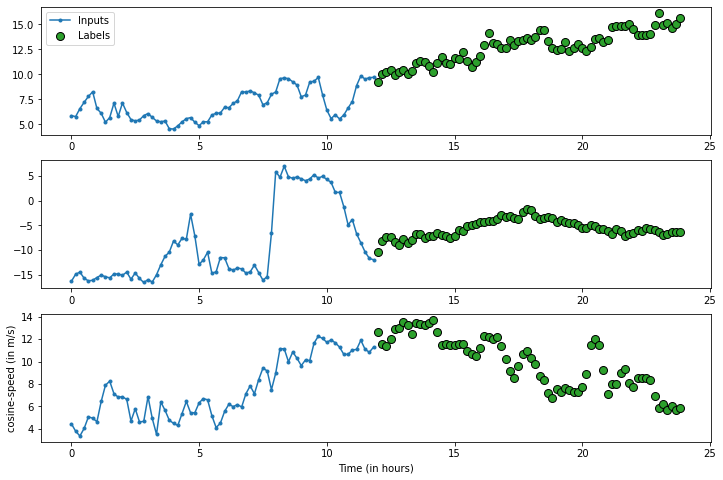

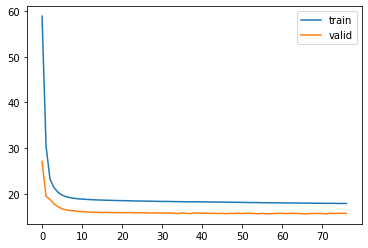

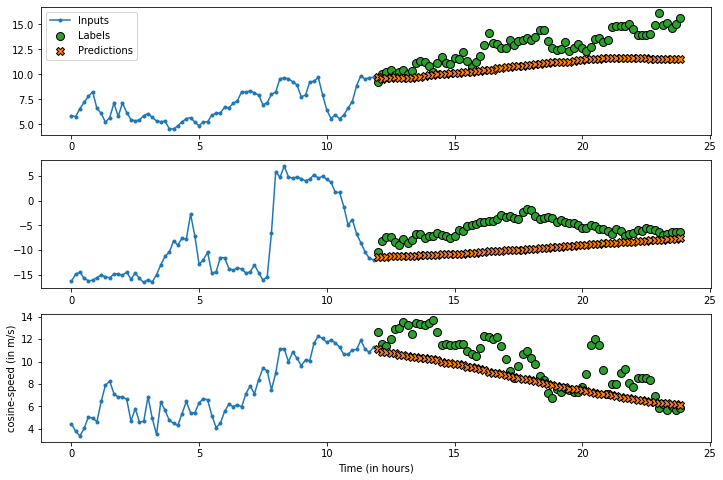

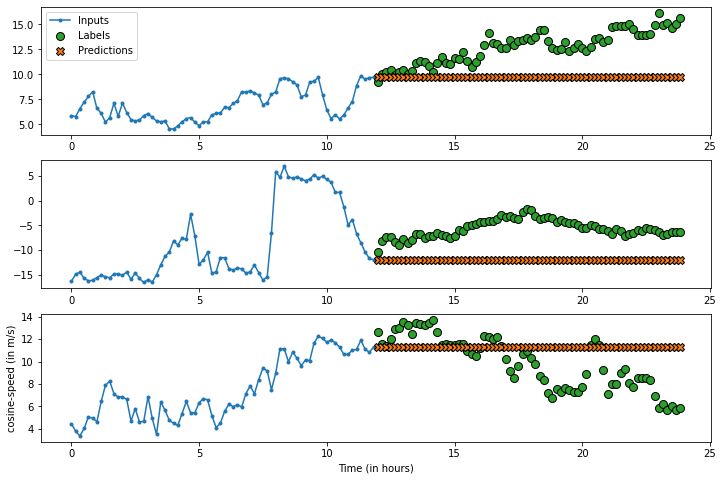

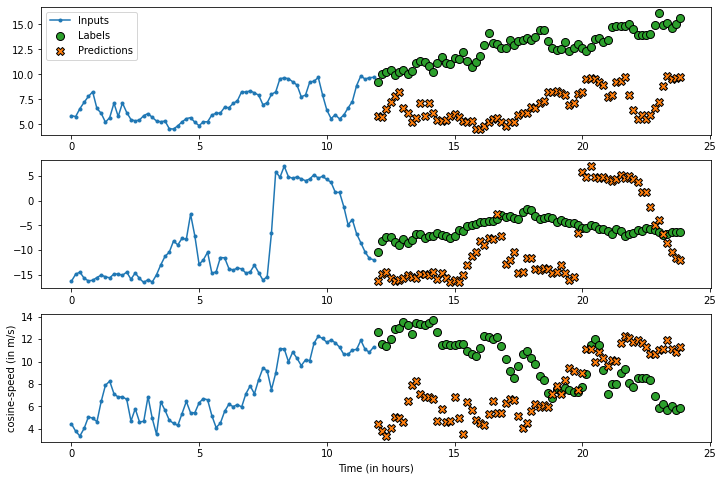

In [ ]:
n = len(speed_direction_df_101)

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 72
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

plot_windows(city_code=speed_direction_df["city_code"].unique()[27],
             train_split=slice(int(n*0.1)+1,int(n*0.8)),
             val_split=slice(0,int(n*0.1)+1),
             test_split=slice(int(n*0.8),n),
             OUT_STEPS=72,
             BATCH_SIZE=128,
             LSTM_UNIT=0,
             CONV_UNIT=32)

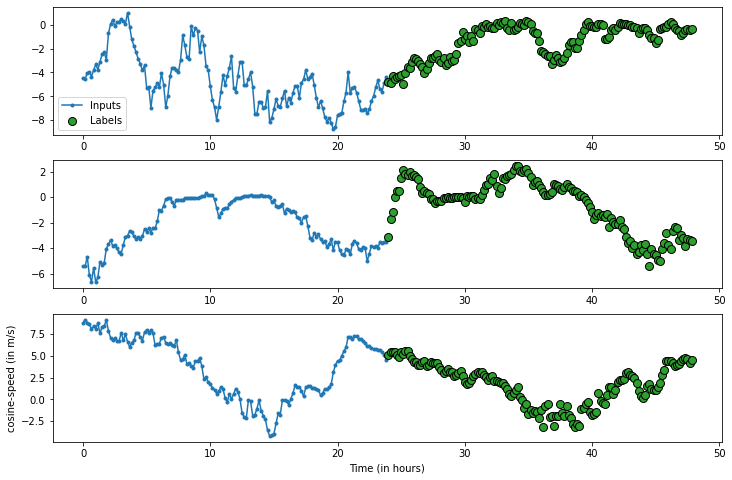

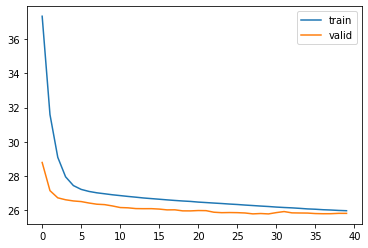

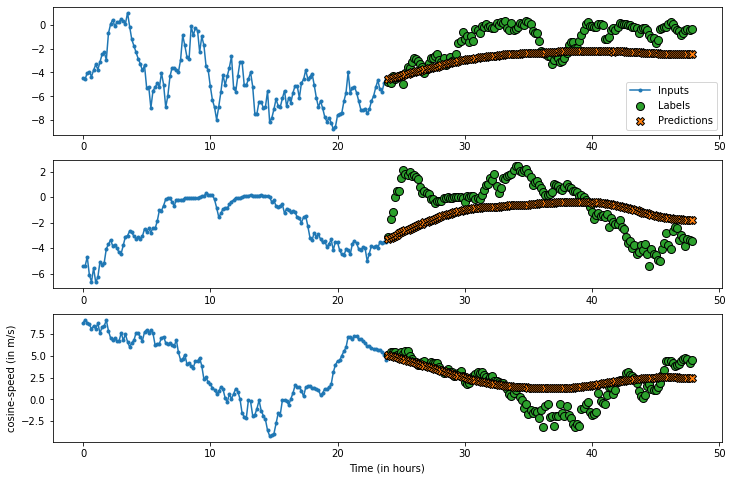

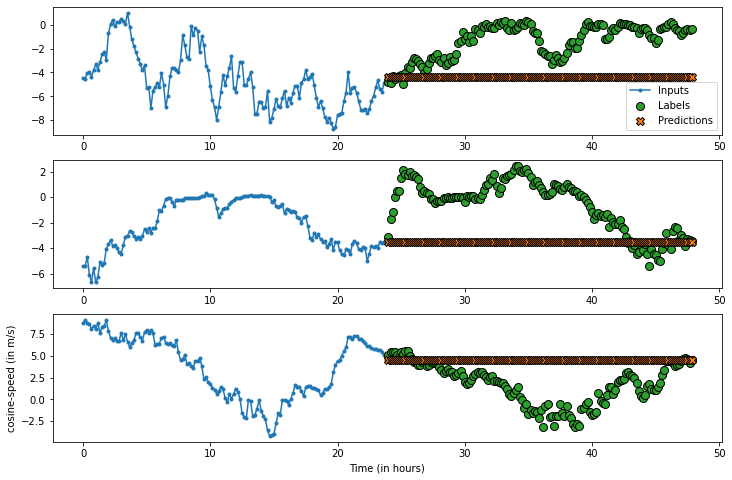

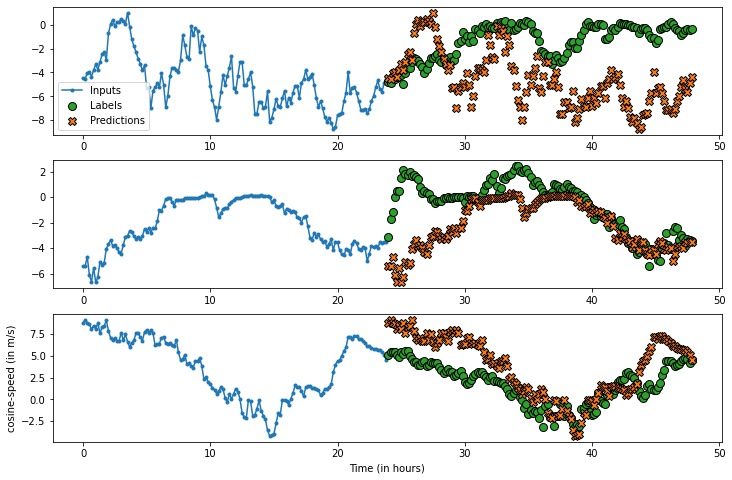

In [ ]:
n = len(speed_direction_df_101)

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    OUT_STEPS = 144
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

plot_windows(city_code=speed_direction_df["city_code"].unique()[3],
             train_split=slice(int(n*0.1)+1,int(n*0.8)),
             val_split=slice(0,int(n*0.1)+1),
             test_split=slice(int(n*0.8),n),
             OUT_STEPS=144,
             BATCH_SIZE=128,
             LSTM_UNIT=0,
             CONV_UNIT=16)